In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

titanic_train_df = pd.read_csv("train.csv")
titanic_test_df = pd.read_csv("test.csv")

In [189]:
titanic_train_df.info()
titanic_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [190]:
def metrics(y_val, y_pred_val):
    val_accuracy = accuracy_score(y_val, y_pred_val)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    val_recall = recall_score(y_val, y_pred_val)
    print(f"Recall Score: {val_recall:.4f}")

    val_precision = precision_score(y_val, y_pred_val)
    print(f"Precision Score: {val_precision:.4f}")

    val_f1 = f1_score(y_val, y_pred_val)
    print(f"F1 Score: {val_f1:.4f}\n")

Удалите все пропущенные значения и категориальные переменные. Обучите модель. Выберете и посчитайте метрику качества.

In [191]:
titanic_train_df_1 = titanic_train_df.copy()
titanic_test_df_1 = titanic_test_df.copy()

for df in [titanic_train_df_1, titanic_test_df_1]:
    df.dropna(inplace=True)

numeric_cols_train = titanic_train_df_1.select_dtypes(
    include=["number"]
).columns.tolist()
numeric_cols_test = titanic_test_df_1.select_dtypes(include=["number"]).columns.tolist()

X = titanic_train_df_1[numeric_cols_train].drop("Survived", axis=1)
y = titanic_train_df_1["Survived"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(X_train, y_train)
y_pred_val = model.predict(X_val)

metrics(y_val, y_pred_val)

Validation Accuracy: 0.6757
Recall Score: 0.8800
Precision Score: 0.7097
F1 Score: 0.7857



Удалите признаки, которые логически не нужны для построения модели. Обоснуйте.
Проверьте данные на наличие пропущенных значений.
a) Посчитайте, какой процент данных будет потерян, если просто удалить пропуски.
b) Заполните пропуски: средним значением; константой; классом, указывающим на то, что значение было пропущено; случайным числом. Для разных признаков используйте подходящий метод. Можно не использовать все перечисленные методы.

In [192]:
def nulls_filler(df, feature, options=("mean", "const", "rand")):
    df = df.copy()

    if options == "mean":
        df[feature] = df.groupby(df.columns.drop(feature).to_list())[feature].transform(
            "mean"
        )
        if df[feature].isnull().any():
            df[feature] = df[feature].fillna(df[feature].mean())

    elif options == "const":
        df[feature] = df[feature].fillna(42)
    elif options == "rand":
        age_values = df[feature].dropna().values
        df[feature] = df[feature].fillna(np.random.choice(age_values))
    else:
        df[feature] = df[feature].fillna(-99999)

    print("You have filled NaNs with: ", options)
    return df

In [193]:
titanic_train_df_2 = titanic_train_df.copy()

titanic_train_df_2.head()
X = titanic_train_df_2.drop(
    ["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1
)
y = titanic_train_df_2["Survived"]

data_miss_pct = (X.isnull().sum() / len(X)) * 100
print("Процент потери данных: ", data_miss_pct)

X["Embarked"] = X["Embarked"].fillna(X["Embarked"].mode()[0])

Процент потери данных:  Pclass       0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Embarked     0.224467
dtype: float64


Категориальные переменные переведите в цифровые значения

In [194]:
X = pd.get_dummies(X, columns=["Sex", "Embarked"], drop_first=True)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,True,False,True
1,1,38.0,1,0,71.2833,False,False,False
2,3,26.0,0,0,7.9250,False,False,True
3,1,35.0,1,0,53.1000,False,False,True
4,3,35.0,0,0,8.0500,True,False,True


Проверьте данные на наличие выбросов.
Удалите выбросы, если считаете это целесообразным. Обоснуйте.

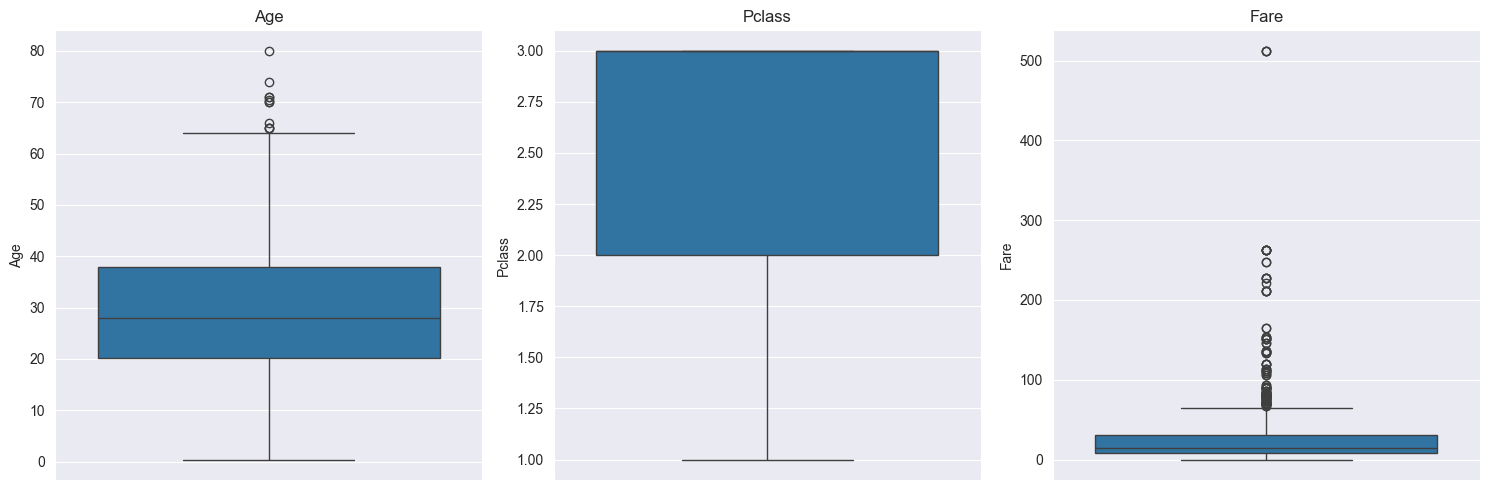

In [195]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(["Age", "Pclass", "Fare"]):
    sns.boxplot(y=X[feature], ax=axes[i])
    axes[i].set_title(f"{feature}")

plt.tight_layout()
plt.show()

<Axes: >

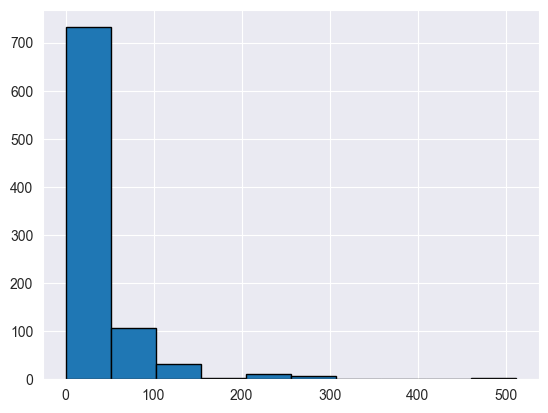

In [196]:
X["Fare"].hist(bins=10, edgecolor="k")

Судя по визуализациям возможных выбросов в признаках возраста и стоимости проезда - они не противоречат здравому смыслу и вполне вероятно, что по сути не являются аномальными данными, поэтому удалять их не будем.

*Попробуйте математически преобразовать признак Age.

Обучите ту же модель, что в п. 2 на преобразованных данных. Посчитайте ту же, что в п. 2 метрику.

In [197]:
X["family_size"] = X["SibSp"] + X["Parch"] + 1
X["family_type"] = pd.cut(
    X["family_size"],
    bins=[1, 2, 5, 8, 100],
    labels=["Loner", "Small", "Medium", "Large"],
    include_lowest=True,
)
X = pd.get_dummies(X, columns=["family_type"], drop_first=True)

С бинами признака Age

In [198]:
for i in ["mean", "const", "rand", "unknown_feature"]:
    X_custom_feat = X.copy()

    X_custom_feat = nulls_filler(X_custom_feat, "Age", options=i)

    X_custom_feat["age_group"] = pd.cut(
        X_custom_feat["Age"],
        bins=[0, 12, 18, 35, 60, 100],
        labels=["Child", "Teen", "Young", "Adult", "Senior"],
        include_lowest=True,
    )
    X_custom_feat = pd.get_dummies(
        X_custom_feat, columns=["age_group"], drop_first=True
    )

    X_custom_feat = X_custom_feat.drop(["Age", "SibSp", "Parch", "family_size"], axis=1)

    X_train, X_val, y_train, y_val = train_test_split(
        X_custom_feat, y, test_size=0.2, random_state=42, stratify=y
    )
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)

    metrics(y_val, y_pred_val)

You have filled NaNs with:  mean
Validation Accuracy: 0.7989
Recall Score: 0.6957
Precision Score: 0.7619
F1 Score: 0.7273

You have filled NaNs with:  const
Validation Accuracy: 0.7989
Recall Score: 0.6812
Precision Score: 0.7705
F1 Score: 0.7231

You have filled NaNs with:  rand
Validation Accuracy: 0.7933
Recall Score: 0.6957
Precision Score: 0.7500
F1 Score: 0.7218

You have filled NaNs with:  unknown_feature
Validation Accuracy: 0.7933
Recall Score: 0.6957
Precision Score: 0.7500
F1 Score: 0.7218



Без бинов признака Age

In [199]:
for i in ["mean", "const", "rand", "unknown_feature"]:
    X_custom_feat = X.copy()

    X_custom_feat = nulls_filler(X_custom_feat, "Age", options=i)

    X_train, X_val, y_train, y_val = train_test_split(
        X_custom_feat, y, test_size=0.2, random_state=42, stratify=y
    )
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)

    metrics(y_val, y_pred_val)

You have filled NaNs with:  mean
Validation Accuracy: 0.7989
Recall Score: 0.6522
Precision Score: 0.7895
F1 Score: 0.7143

You have filled NaNs with:  const
Validation Accuracy: 0.8101
Recall Score: 0.6667
Precision Score: 0.8070
F1 Score: 0.7302

You have filled NaNs with:  rand
Validation Accuracy: 0.7877
Recall Score: 0.6522
Precision Score: 0.7627
F1 Score: 0.7031

You have filled NaNs with:  unknown_feature
Validation Accuracy: 0.7877
Recall Score: 0.6667
Precision Score: 0.7541
F1 Score: 0.7077

